In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import the data
df = pd.read_csv("champions_league_rawData.csv")

# Tidy the Data

### Identify the date of each match

In [3]:
# separate the match month, day, and time
df[['day', 'month', 'start_time']] = df.pop('match_time').str.split('.', expand=True)
df[['day', 'month']] = df[['day', 'month']].astype('int64')

In [4]:
# identify the year of the match
# note: July (month 7) always separates the beginning and end of successive seasons in the water polo Champions League
df[['a', 'b']] = df['season'].str.split('/', expand=True)
df['year'] = np.where(df['month'] > 7, df['a'], df['b'])
df.drop(['a', 'b'], axis=1, inplace=True)

In [5]:
# combine the day, month, year into a datetime variable
df['date'] = pd.to_datetime(df[['day', 'month', 'year']])

### Remove the qualification matches from the data set

In [ ]:
from collections import Counter
Counter(df.event_name)

In [6]:
# remove the qualifying round matches
df = df[~df['event_name'].str.contains('Qualification')]

# Calculate Elo Ratings

In [7]:
# set elo parameter values
elo_start = 1500
elo_width = 400
k = 40   #k should be set to minimize autocorrelation

In [8]:
# select the columns needed to compute elo
df_elo = df.drop(['event_name', 
                  'event_round',  
                  'day', 
                  'month', 
                  'start_time', 
                  'year'], axis=1)

# sort matches chronologically since elo is a form of time series analysis
df_elo.sort_values(by=['season', 'date'], inplace=True)

The code in the next two code blocks is adapted from: https://github.com/danielguerreros/InternationalELo/blob/main/calculate_elo.ipynb

In [12]:
# function to calculate the expected result from teams' current elo ratings
def expected_result(home_elo, away_elo):
    diff = home_elo - away_elo
    exp_res = 1/(1+10**(-diff/elo_width))
    return [exp_res, 1-exp_res]

# function to assign weights for the outcome of the match
def actual_result(home_score, away_score):
    if home_score > away_score:
        wh = 1
        wa = 0
    elif home_score < away_score:
        wh = 0
        wa = 1
    elif home_score == away_score:
        wh = 0.5
        wa = 0.5
    return [wh, wa]

# function to update elo ratings for the current match results
def calculate_elo(elo_home, elo_away, home_score, away_score, k=40):
    wh, wa = actual_result(home_score, away_score)
    exp_home, exp_away = expected_result(elo_home, elo_away)

    rating_home = elo_home + k*(wh-exp_home)  ##use another multiplier on the last term here to account for goal differential
    rating_away = elo_away + k*(wa-exp_away)

    return [rating_home, rating_away]

In [10]:
current_elo={}

for idx, row in df_elo.iterrows():
    
    home = row['home_team']
    away = row['away_team']
    
    # initially assign a default rating for each team
    if home not in current_elo.keys():
        current_elo[home] = elo_start
    
    if away not in current_elo.keys():
        current_elo[away] = elo_start
    

    # record elo before match
    df_elo.loc[idx,'Elo_h_before'] = np.round(current_elo[home], 1)
    df_elo.loc[idx,'Elo_a_before'] = np.round(current_elo[away], 1)
    
    # calculate new elo from match result
    elo_h_new, elo_a_new = calculate_elo(current_elo[home], 
                                         current_elo[away], 
                                         row['home_score'], 
                                         row['away_score'])

    # update current elo value
    current_elo[home] = elo_h_new
    current_elo[away] = elo_a_new
    
    # record post-match elo
    df_elo.loc[idx,'Elo_h_after'] = np.round(elo_h_new, 1)
    df_elo.loc[idx,'Elo_a_after'] = np.round(elo_a_new, 1)

(This is the end of the code adapted from: https://github.com/danielguerreros/InternationalELo/blob/main/calculate_elo.ipynb)

### Tune the k value

In [11]:
df_elo.head()

,away_score,away_team,home_score,home_team,season,date,Elo_h_before,Elo_a_before,Elo_h_after,Elo_a_after
56,6,Barceloneta,7,Jadran HN,2008/2009,2008-11-19,1500.0,1500.0,1520.0,1480.0
57,6,Budva,7,Mladost,2008/2009,2008-11-19,1500.0,1500.0,1520.0,1480.0
58,7,Leonessa,10,Olympiacos,2008/2009,2008-11-19,1500.0,1500.0,1520.0,1480.0
59,6,Sibenik,13,Primorac,2008/2009,2008-11-19,1500.0,1500.0,1520.0,1480.0
54,9,Pro Recco,10,Jug Dubrovnik,2008/2009,2008-11-22,1500.0,1500.0,1520.0,1480.0


In [19]:
# do you need a dynamic k value, depending on how many games the team has historically already played?

# find log-loss for k=40
df_elo[['actual_home', 'actual_away']] = df_elo.apply(lambda x: actual_result(x['home_score'], x['away_score']), axis=1, result_type='expand')
df_elo[['pred_home', 'pred_away']] = df_elo.apply(lambda x: expected_result(x['Elo_h_before'], x['Elo_a_before']), axis=1, result_type='expand')

df_elo.tail()

,away_score,away_team,home_score,home_team,season,date,Elo_h_before,Elo_a_before,Elo_h_after,Elo_a_after,actual_home,actual_away,pred_home,pred_away
1556,8,OSC Ujbuda,13,Jug Dubrovnik,2022/2023,2023-02-28,1656.4,1501.4,1668.0,1489.7,1.0,0.0,0.709355,0.290645
1549,9,Barceloneta,8,Pro Recco,2022/2023,2023-03-01,1985.1,1818.1,1956.1,1847.0,0.0,1.0,0.723388,0.276612
1550,13,Jadran ST,11,Radnicki,2022/2023,2023-03-01,1528.0,1438.4,1502.9,1463.4,0.0,1.0,0.626160,0.373840
1551,10,Dinamo Tbilisi,8,Hannover,2022/2023,2023-03-01,1430.0,1303.7,1403.0,1330.7,0.0,1.0,0.674156,0.325844
1552,14,Olympiacos,6,Vouliagmeni,2022/2023,2023-03-01,1517.2,1682.0,1506.0,1693.2,0.0,1.0,0.279153,0.720847


Need to account for probability of a draw before this will work ... 

In [30]:
from sklearn.metrics import log_loss
log_loss(df_elo['actual_home'], df_elo['pred_home'], labels=['0.0','0.5','1.0'])

ValueError: continuous target data is not supported with label binarization

In [11]:
# save data by exporting to a cvs file
df_elo.to_csv('champions_league_eloData.csv', index=False)

# Calculate the Expected Win Odds for Scheduled Matches with Elo

In [12]:
# convert dict of current elo ratings into a dataframe
current_elo_df = pd.DataFrame(current_elo.items(), columns=['team', 'elo_rating']).set_index('team')
#current_elo_df.sort_values(by='elo_rating', ascending=False)

In [13]:
# read in the scheduled matches
df_scheduled = pd.read_csv("champions_league_scheduledGames.csv")

In [14]:
# calculate the Elo odds of each team winning scheduled matches
df_scheduled['home_elo'] = df_scheduled.apply(lambda x: current_elo_df.loc[x['home_team']], axis=1)
df_scheduled['away_elo'] = df_scheduled.apply(lambda x: current_elo_df.loc[x['away_team']], axis=1)
df_scheduled[['home_win_odds', 'away_win_odds']] = df_scheduled.apply(lambda x: expected_result(x['home_elo'], x['away_elo']), axis=1, result_type='expand')

In [15]:
# save data by exporting to a cvs file
df_scheduled.to_csv('champions_league_scheduledOdds.csv', index=False)

# Create Time Series of Elo Ratings

In [16]:
# reorganize data into a time series of elo rating for all teams
home = df_elo[['date', 
               'home_team', 
               'Elo_h_after', 
               'away_team', 
               'away_score', 
               'home_score']].rename(columns={'home_team':'team','Elo_h_after':'elo', 'away_team':'opponent'})
home['result'] = np.select([home['home_score']>home['away_score'], 
                            home['home_score']==home['away_score'],
                            home['home_score']<home['away_score']],
                           ['W', 'D', 'L'])
home['score'] = home['home_score'].astype('str') + '-' + home['away_score'].astype('str') + ' ' + home['result']
home = home.drop(['away_score', 'home_score', 'result'], axis=1)

away = df_elo[['date', 
               'away_team', 
               'Elo_a_after',
               'home_team', 
               'away_score', 
               'home_score']].rename(columns={'away_team':'team', 'Elo_a_after':'elo', 'home_team':'opponent'})
away['result'] = np.select([away['home_score']<away['away_score'], 
                            away['home_score']==away['away_score'],
                            away['home_score']>away['away_score']],
                           ['W', 'D', 'L'])
away['score'] = away['away_score'].astype('str') + '-' + away['home_score'].astype('str') + ' ' + away['result']
away = away.drop(['away_score', 'home_score', 'result'], axis=1)

df_elo_ts = home.append(away)

In [17]:
# save data by exporting to a cvs file
df_elo_ts.to_csv('champions_league_elo_timeseriesData.csv', index=False)

# Tablulate Appearances Data

In [18]:
# identify dates of first and most recent matches, and the number of appearances in the data set 
df_appear = df_elo_ts.groupby('team').agg({'date': ['min', 'max', 'count']}).sort_values(by=('date', 'count'), ascending=False)
df_appear.columns = df_appear.columns.to_flat_index()   #flatten multi-index to rename columns
df_appear.rename(columns={('date', 'min'):'first_app', 
                          ('date', 'max'):'last_app', 
                          ('date', 'count'):'num_app'}, inplace=True)
#df_appear.head(10)

In [19]:
# identify team participating in this year's season
df_appear['active'] = (df_appear['last_app'] > '2023-01-01')

In [20]:
# save data by exporting to a cvs file
df_appear.to_csv('champions_league_appearanceData.csv', index=True)

# Visualize Data

Text(0.5, 1.0, 'Top 6 Teams by Number of Games Played')

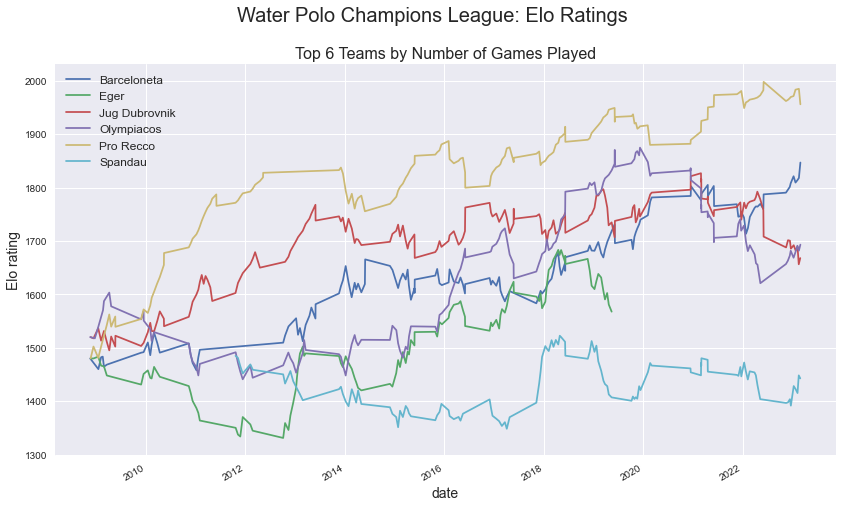

In [21]:
# plot the team Elo ratings over time
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(14,8))

num_teams = 6  #number of team to show in the plot
plot_teams = df_appear.head(num_teams).index
df_plot = df_elo_ts[df_elo_ts['team'].isin(plot_teams)]

for key, grp in df_plot.groupby('team'):
    ax = grp.plot(ax=ax, kind='line', x='date', y='elo', label=key)

ax.legend(loc='best', fontsize=12)
ax.set_xlabel('date', fontsize=14)
ax.set_ylabel('Elo rating', fontsize=14)
plt.suptitle('Water Polo Champions League: Elo Ratings', size=20)
plt.title(f'Top {num_teams} Teams by Number of Games Played', size=16)
#plt.show()

[Text(0.5, 0, 'first appearance'), Text(0, 0.5, 'matches played')]

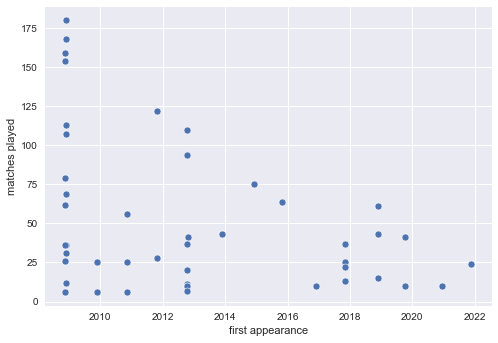

In [22]:
# visualize the relationship between first appearance and number of appearances
ax = sns.scatterplot(data=df_appear, x='first_app', y='num_app')
ax.set(xlabel='first appearance', ylabel='matches played')